In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from scipy.stats import lognorm as lnorm
from primitives import Parameters
p = Parameters()
import opt_einsum as oe
from primitives import Preferences
from probabilities import createPoissonTransitionMatrix,createBlockPoissonTransitionMatrix
from search import JobSearchArray
import matplotlib.pyplot as plt
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
def impose_decreasing(M):
    nv = M.shape[1]
    for v in reversed(range(nv-1)):
        M[:,v,:] = np.maximum(M[:,v,:],M[:,v+1,:])
    return M
def impose_increasing(A0):
    A = np.copy(A0)
    nv = len(A)
    for v in range(1,nv):
        A[v] = np.maximum(A[v],A[v-1])
    return A
ax = np.newaxis
class StateBoundsProcessor:
    def __init__(self, lower_bounds, upper_bounds):
        """
        Initialize with lower and upper bounds for each state dimension
        
        Args:
            lower_bounds: List or tensor of lower bounds [x_1, x_2, ..., x_20]
            upper_bounds: List or tensor of upper bounds [y_1, y_2, ..., y_20]
        """
        self.lower_bounds = torch.tensor(lower_bounds, dtype=torch.float32)
        self.upper_bounds = torch.tensor(upper_bounds, dtype=torch.float32)
        self.range = self.upper_bounds - self.lower_bounds
        
    def normalize(self, states):
        """Scale states from [lower_bound, upper_bound] to [-1, 1]"""
        return 2 * (states - self.lower_bounds) / self.range - 1
        #Example: lower-upper is [0,1]. So normalize(0.5) = 2 * (0.5 - 0) /1 -1 = 0. Ok correct
        #Another example. lower-upper is [0,30]. Sn normalize 15= 2 * 15 / 30 -1 = 0 Ok good.
        # And normalize (20) = 40/30 - 1 = 1/3 yup
        # Now denormalize(1/3) = 0.5 ( 1/3 +1 ) * 30 + 0 = 2/3*30 = 20
        
    def denormalize(self, normalized_states):
        """Convert normalized states back to original range"""
        return 0.5 * (normalized_states + 1) * self.range + self.lower_bounds
class ValueFunctionNN(nn.Module):
    """Neural network to approximate the value function"""
    def __init__(self, state_dim, hidden_dims=[40, 30, 20, 10]):
        super(ValueFunctionNN, self).__init__()
        
        # Build layers
        layers = []
        input_dim = state_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.Softplus())  # SiLU activation function
            # Consider adding layer normalization for stability
            #layers.append(nn.LayerNorm(hidden_dim))
            input_dim = hidden_dim
        
        # Output layer
        layers.append(nn.Linear(input_dim, 1)) #was input_dim instead of 16
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)


In [4]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)  
cc.w_grid[0]

0.05

In [6]:
cc_J,cc_W,_,cc_rho_star = cc.J(0)

In [7]:
cc.v_grid

array([-5.55541753e+02, -5.52232994e+02, -5.48924235e+02, -5.45615476e+02,
       -5.42306717e+02, -5.38997958e+02, -5.35689199e+02, -5.32380440e+02,
       -5.29071681e+02, -5.25762922e+02, -5.22454163e+02, -5.19145404e+02,
       -5.15836646e+02, -5.12527887e+02, -5.09219128e+02, -5.05910369e+02,
       -5.02601610e+02, -4.99292851e+02, -4.95984092e+02, -4.92675333e+02,
       -4.89366574e+02, -4.86057815e+02, -4.82749056e+02, -4.79440297e+02,
       -4.76131538e+02, -4.72822779e+02, -4.69514020e+02, -4.66205261e+02,
       -4.62896502e+02, -4.59587743e+02, -4.56278985e+02, -4.52970226e+02,
       -4.49661467e+02, -4.46352708e+02, -4.43043949e+02, -4.39735190e+02,
       -4.36426431e+02, -4.33117672e+02, -4.29808913e+02, -4.26500154e+02,
       -4.23191395e+02, -4.19882636e+02, -4.16573877e+02, -4.13265118e+02,
       -4.09956359e+02, -4.06647600e+02, -4.03338841e+02, -4.00030083e+02,
       -3.96721324e+02, -3.93412565e+02, -3.90103806e+02, -3.86795047e+02,
       -3.83486288e+02, -

In [8]:
cc_J.min(),cc_J.max(),cc_W.min(),cc_W.max()

(-8385.574702144228, 90.54769141022722, 3.199021364545065, 102.90127657534775)

In [ ]:
cc.fun_prod

array([2.03766514, 4.        , 7.85212434])

NameError: name 'cc' is not defined

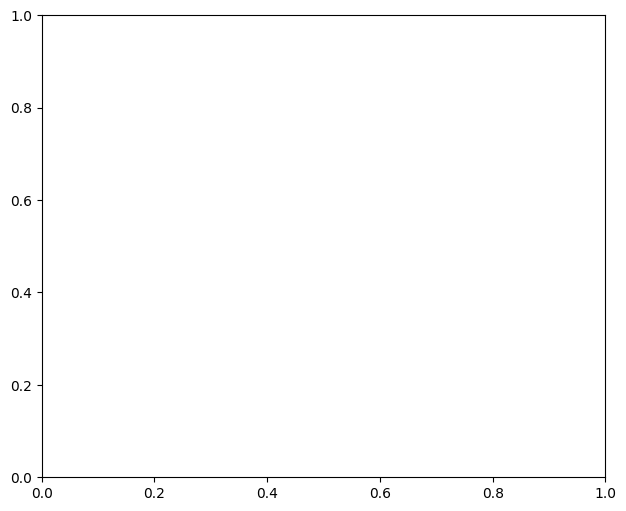

In [3]:
    plt.figure(figsize=(16, 6))
    plt.subplot(1,2,1)
    plt.plot(cc.rho_grid, cc_Jp[p.z_0-1,:]+ cc.rho_grid[:] * cc_W[p.z_0-1,:], label = "VFI")
    #Plot the policy functions
    plt.subplot(1,2,2)
    plt.plot(cc.rho_grid, cc_W[p.z_0-1,:], label = "VFI")
    plt.show()

In [3]:
class FOCOptimizer:
    """
    Class to solve first-order conditions given a state and value function
    This is a placeholder - you'll need to implement actual FOC logic
    """
    def __init__(self, state_dim, action_dim, value_function_model, bounds_processor, parameters=None, js=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.bounds_processor = bounds_processor  # Store bounds_processor

        self.p = parameters
        self.deriv_eps = 1e-4 # step size for derivative
        # Model preferences initialized by the same parameter object.
        self.pref = Preferences(input_param=self.p)

        # Worker and Match Productivity Heterogeneity in the Model
        self.Z_grid = self.construct_z_grid()   # Create match productivity grid

        # Production Function in the Model
        self.fun_prod = self.p.prod_a * np.power(self.Z_grid, self.p.prod_rho)
        # Unemployment Benefits across Worker Productivities
        self.unemp_bf = self.p.u_bf_m

        # Transition matrices
        self.Z_trans_mat = createPoissonTransitionMatrix(self.p.num_z, self.p.z_corr)

        # Value Function Setup
        self.J_grid   = -10 * np.ones((self.p.num_v)) #grid of job values, first productivity, then starting value, then tenure level
        self.w_grid = np.linspace(self.unemp_bf, self.fun_prod.max(), self.p.num_v )
        self.rho_grid=1/self.pref.utility_1d(self.w_grid)
        # Normalize rho_grid to tensor for model input
        self.rho_normalized = self.bounds_processor.normalize(torch.tensor(self.rho_grid, dtype=torch.float32)).unsqueeze(1)

        
        #Gotta fix the tightness+re functions somehow. Ultra simple J maybe?
        self.v_grid=np.linspace(np.divide(self.pref.utility(self.unemp_bf),1-self.p.beta), np.divide(self.pref.utility(self.fun_prod.max()),1-self.p.beta), self.p.num_v ) #grid of submarkets the worker could theoretically search in. only used here for simplicity!!!
        self.simple_J=np.divide(self.fun_prod[self.p.z_0-1,ax] -self.pref.inv_utility(self.v_grid[:]*(1-self.p.beta)),1-self.p.beta)
        self.simple_Rho = self.simple_J + self.rho_grid * self.v_grid #We do indeed need to work with Rho here since we're taking W via its derivatives
        #Apply the matching function: take the simple function and consider its different values across v.
        self.prob_find_vx = self.p.alpha * np.power(1 - np.power(
            np.divide(self.p.kappa, np.maximum(self.simple_J[ :], 1.0)), self.p.sigma), 1/self.p.sigma)
        #Now get workers' probability to find a job while at some current value, as well as their return probabilities.
        if js is None:
            self.js = JobSearchArray() #Andrei: note that for us this array will have only one element
            self.js.update(self.v_grid[:], self.prob_find_vx) #Andrei: two inputs: worker's value at the match quality of entrance (z_0-1), and the job-finding probability for the whole market
        else:
            self.js = js
        #Note: I think??? js takes the values over the uniform grid only. so if I use NNs, gotta adapt it. But for now forget about updating it, keep it as is

    def getWorkerDecisions(self, EW1, employed=True): #Andrei: Solves for the entire matrices of EW1 and EU
        """
        :param EW1: Expected value of employment
        :param EU:  Expected value of unemployment
        :param employed: whether the worker is employed (in which case we multiply by efficiency)
        :return: pe,re,qi search decision and associated return, as well as quit decision.
        """
        pe, re = self.js.solve_search_choice(EW1) #Uses the job search array to solve for the search choice
        assert (~np.isnan(pe)).all(), "pe is not NaN"
        assert (pe <= 1).all(), "pe is not less than 1"
        assert (pe >= -1e-10).all(), "pe is not larger than 0"
        ve = self.js.ve(EW1)
        if employed:
            pe = pe * self.p.s_job
            re = re * self.p.s_job
        #print("Shape of pe:", pe.shape)
        # construct the continuation probability. #Andrei: probability the worker doesn't get fired and also doesn't leave
        pc = (1 - pe)

        return ve, re, pc #ve is vhat, the value the worker gets upon finding a job
    def matching_function(self,J1): #Andrei: the formula of their matching function, applied to each particula job value J1
        return self.p.alpha * np.power(1 - np.power(
            np.divide(self.p.kappa, np.maximum(J1, self.p.kappa)), self.p.sigma),
                                1 / self.p.sigma)
    def construct_z_grid(self):
        """
            Construct a grid for match productivity heterogeneity.
        """

        exp_z = np.tile(np.linspace(0, 1, self.p.num_z + 2)[1:-1][:],
                        (1))

        return lnorm.ppf(q=exp_z, s=self.p.prod_var_z)    
    def solve_foc(self, states, value_function_model):
        """
        Solves first-order conditions to find optimal action and next state
        
        Args:
            state: Current state tensor
            value_function_model: Neural network model for value function
        
        Returns:
            Dictionary with optimal action, next state, and immediate reward
        """
        # This is a placeholder - replace with your actual FOC solver
        # In a real implementation, you would:
        # 1. Set up an optimization problem to find action that maximizes reward + discounted future value
        # 2. Use value_function_model to evaluate future values
        # 3. Return optimal action and resulting next state
        # Compute gradient with gradients enabled
        EW=self.EW
        with torch.no_grad():
            self.vf_output = value_function_model(self.rho_normalized).squeeze(1).numpy() #This EJpi from the CC FOC. I just precompute it for every point here
        # Placeholder implementation (just random actions and states)
        with torch.no_grad():
            states_denorm = self.bounds_processor.denormalize(states).numpy()
            # get worker decisions
            _, _, pc = self.getWorkerDecisions(EW) #This EW1i is computed by taking the derivative of Rho, which is our core value function, wrt rho, which is the value-related state-variable
            # get worker decisions at EW1i + epsilon
            _, _, pc_d = self.getWorkerDecisions(EW + self.deriv_eps)
            log_diff = np.zeros_like(self.rho_grid)
            log_diff[:] = np.nan
            log_diff[pc > 0] = np.log(pc_d[pc > 0]) - np.log(pc[pc > 0]) #This is log derivative of pc wrt the promised value
            foc = self.rho_grid[:] - self.vf_output * log_diff / self.deriv_eps #So the FOC wrt promised value is: pay shadow cost lambda today (rho_grid), but more likely that the worker stays tomorrow
            assert (np.isnan(foc) & (pc > 0)).sum() == 0, "foc has NaN values where p>0"

                    #Andrei: so we look for the shadow cost that will satisfy the foc? Yes, look for u'(w'), with u'(w) given, so that the foc is satisfied
                    # look for FOC below  rho_0

            rho_star = np.interp(states_denorm,
                                        impose_increasing(foc),
                                        self.rho_grid)
            rho_star_tensor = torch.tensor(rho_star, dtype=torch.float32)

            action = rho_star_tensor
            next_state = self.bounds_processor.normalize(rho_star_tensor)
            reward = self.fun_prod[p.z_0-1] - np.interp(rho_star,self.rho_grid,self.w_grid) + states_denorm * self.pref.utility(np.interp(rho_star,self.rho_grid,self.w_grid))  # The entire Rho here. Big note though: this should be today's W, not EW
            reward = torch.tensor(reward, dtype=torch.float32)



        return {
            "action": action,
            "next_state": next_state,
            "reward": reward
        }
    def get_batch_gradients(self,states, value_function_model):
        states = states.detach().clone().requires_grad_(True)
        values = value_function_model(states)
    
        # Sum values to get scalar for backward pass
        values.sum().backward(retain_graph=True)
    
        gradients = states.grad.clone()
        # Clear gradients for next computation
        states.grad.zero_()
        gradients = gradients / (0.5 * self.bounds_processor.range) #Normalize the gradient back to the original (not [-1,1]) state space

        return gradients    
    def get_value_function_gradient(self,state, value_function_model):
        # Ensure state requires gradients
        #if not state.requires_grad:
        state = state.detach().clone().requires_grad_(True)
    
        # Forward pass
        value = value_function_model(state)
    
        # Compute gradient of value with respect to state
        #value.retain_grad()
        value.sum().backward(retain_graph=True)

        # Extract gradient
        gradient = state.grad.clone()
    
        # Clear gradients for next computation
        state.grad.zero_()
        gradient = gradient / (0.5 * self.bounds_processor.range) #Normalize the gradient back to the original (not [-1,1]) state space
        return gradient
    #This can definitely be vectorized. So far each trajectory is done completely separately, even though the operations at each step are the same, no?
    def simulate_trajectory(self,state, value_function_model, foc_optimizer, steps=5):
        """
        Simulate a trajectory starting from a state and using the current value function
    
        Args:
            state: Starting state tensor
            value_function_model: Current value function model
            foc_optimizer: Optimizer to solve FOCs
            steps: Number of steps to simulate
        
        Returns:
            Total discounted reward and final state value
        """
        total_reward = 0
        discount = 1.0
    
        current_state = state.clone()
        with torch.enable_grad():
            EW_tensor = self.get_batch_gradients(self.rho_normalized, value_function_model)[:,0] #This isn't even correct! I should be taking this at all the rho's!
        self.EW = EW_tensor.detach().numpy()  # Convert to NumPy for further processing
        for _ in range(steps):
            
            # Solve FOC to get optimal action and next state
            result = foc_optimizer.solve_foc(current_state, value_function_model)
            #Probability that the worker stays
            EW_star = self.get_batch_gradients(result["next_state"].unsqueeze(1).requires_grad_(True), value_function_model)[:,0]
            ve_star, __, pc_star = self.getWorkerDecisions(EW_star.numpy())
            ve_star = torch.from_numpy(ve_star)
            pc_star = torch.from_numpy(pc_star)            
            # Accumulate discounted reward
            if _<range(steps)[-1]:
                total_reward += discount * result["reward"] + self.p.beta * self.bounds_processor.denormalize(current_state) * ( 1 - pc_star) * ve_star  #This should be: reward + rho*beta*ve_star*pe_star (so the value worker gets from leaving) + discount*next_reward
            else:
                total_reward += discount * result["reward"] #for the last period we don't enymore do ve_star as that's included... right? confirm later
            # Update state and discount factor
            current_state = result["next_state"]
            discount *= self.p.beta * pc_star
    
        # Add final state value
        with torch.no_grad():
            final_value = value_function_model(current_state.unsqueeze(1).requires_grad_(True))
    
        total_value = total_reward + discount * final_value
    
        return total_value, current_state

In [4]:
def train_value_function(
    state_dim,
    lower_bounds,
    upper_bounds,
    action_dim=5,
    hidden_dims=[40, 30, 20, 10],
    num_iterations=20, 
    starting_points_per_iter=100,
    simulation_steps=5,
    learning_rate=0.001,
    parameters=None
):
    """
    Main training loop for value function approximation
    
    Args:
        state_dim: Dimension of state space
        action_dim: Dimension of action space
        hidden_dims: List of hidden layer dimensions
        num_iterations: Number of training iterations
        starting_points_per_iter: Number of starting points per iteration
        simulation_steps: Steps to simulate for each starting point
        learning_rate: Learning rate for neural network optimizer
        discount_factor: Discount factor for future rewards
    
    Returns:
        Trained value function model
    """
    bounds_processor = StateBoundsProcessor(lower_bounds,upper_bounds)
    # Initialize value function neural network
    value_function_model = ValueFunctionNN(state_dim, hidden_dims)
    from ContinuousContract import ContinuousContract
    cc=ContinuousContract(p)
    # Initialize FOC optimizer
    foc_optimizer = FOCOptimizer(state_dim, action_dim, value_function_model, bounds_processor, parameters, cc.js)
    
    # Initialize neural network optimizer
    optimizer = optim.Adam(value_function_model.parameters(), lr=learning_rate)
    
    #Step 0: basic guess    
    cc_J,cc_W,_,_ = cc.J(0)
    target_values = torch.tensor(cc_J[p.z_0-1,:] + cc.rho_grid * cc_W[p.z_0-1,:], dtype=torch.float32)
    states=bounds_processor.normalize(torch.tensor(foc_optimizer.rho_grid, dtype=torch.float32)).unsqueeze(1).requires_grad_(True) #This should be renormalized... right?
    #print(np.max(np.abs(cc.rho_grid-foc_optimizer.rho_grid)))
    #target_values=torch.tensor(foc_optimizer.simple_Rho, dtype=torch.float32)
    for _ in (range(50)):
        optimizer.zero_grad()
        predicted_values = value_function_model(states)[:,0]
        loss = nn.MSELoss()(predicted_values, target_values)
        loss.backward() #
        optimizer.step()

    # Training loop
    for iteration in tqdm(range(num_iterations)):
        # Generate uniform random starting states
        states_denormal = torch.rand(starting_points_per_iter, state_dim,dtype=torch.float32) * bounds_processor.range + torch.tensor(lower_bounds,dtype=torch.float32) #Turning lower_bounds into torch every time is wasteful
        states = bounds_processor.normalize(states_denormal).requires_grad_(True)
        #print("States shape", states.shape)
        # Calculate target values through simulation
        target_values = []

        # Simulate trajectory and get total discounted reward
        target_values, _ = foc_optimizer.simulate_trajectory(
            states[:,0], value_function_model, foc_optimizer, simulation_steps)
        #target_values.append(total_values)
        
        #target_values = torch.tensor(target_values, dtype=torch.float32)
        
        # Update neural network based on simulated values
        optimizer.zero_grad()
        predicted_values = value_function_model(states)
        loss = nn.MSELoss()(predicted_values, target_values)
        loss.backward() #
        optimizer.step()
        
        # Print progress
        if (iteration + 1) % 5 == 0 or iteration == 0:
            print(f"Iteration {iteration + 1}, Loss: {loss.item():.6f}")
    
    return value_function_model

In [5]:
def evaluate_value_function(model, p, lower_bounds,upper_bounds):
    """
    Evaluate the trained value function on test points
    
    Args:
        model: Trained value function model
        num_test_points: Number of test points
        state_dim: Dimension of state space
    """

    bounds_processor = StateBoundsProcessor(lower_bounds,upper_bounds)
    # Generate random test states
    #test_states = torch.randn(num_test_points, state_dim)
    from ContinuousContract import ContinuousContract
    cc=ContinuousContract(p)    
    cc_J,cc_W,_,_ = cc.J(0)
    cc_Rho = cc_J[p.z_0-1,:] + cc.rho_grid * cc_W[p.z_0-1,:]
    test_states = bounds_processor.normalize(torch.tensor(cc.rho_grid, dtype=torch.float32)).unsqueeze(1)
    # Evaluate model
    with torch.no_grad():
        values = model(test_states)
    
    # Print results
    #print("\nValue function evaluation on test states:")
    #for i in range(min(5, num_test_points)):
    #    print(f"State {i+1}: Value = {values[i].item():.4f}")
    #Plot results
    plt.plot(cc.rho_grid, cc_Rho, label = "VFI")
    plt.plot(cc.rho_grid, values, label = "NN")    
    plt.show()

In [11]:
bounds_processor = StateBoundsProcessor(LOWER_BOUNDS,UPPER_BOUNDS)
foc_optimizer = FOCOptimizer(STATE_DIM, ACTION_DIM, trained_model, bounds_processor, p, cc.js)

In [13]:
foc_optimizer.rho_normalized

tensor([[-1.0000e+00],
        [-9.9774e-01],
        [-9.9461e-01],
        [-9.9080e-01],
        [-9.8643e-01],
        [-9.8156e-01],
        [-9.7623e-01],
        [-9.7049e-01],
        [-9.6435e-01],
        [-9.5785e-01],
        [-9.5099e-01],
        [-9.4381e-01],
        [-9.3632e-01],
        [-9.2851e-01],
        [-9.2042e-01],
        [-9.1205e-01],
        [-9.0340e-01],
        [-8.9449e-01],
        [-8.8532e-01],
        [-8.7591e-01],
        [-8.6625e-01],
        [-8.5635e-01],
        [-8.4622e-01],
        [-8.3586e-01],
        [-8.2529e-01],
        [-8.1449e-01],
        [-8.0349e-01],
        [-7.9227e-01],
        [-7.8085e-01],
        [-7.6923e-01],
        [-7.5741e-01],
        [-7.4540e-01],
        [-7.3319e-01],
        [-7.2080e-01],
        [-7.0822e-01],
        [-6.9546e-01],
        [-6.8251e-01],
        [-6.6939e-01],
        [-6.5610e-01],
        [-6.4263e-01],
        [-6.2899e-01],
        [-6.1518e-01],
        [-6.0120e-01],
        [-5

In [3]:
range(3)[1:]

range(1, 3)

Training value function...


  0%|          | 0/690 [00:00<?, ?it/s]c:\Programs\Python 3.11\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([200, 200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|          | 8/690 [00:00<00:08, 76.93it/s]

Iteration 1, Loss: 1072808.125000
Iteration 5, Loss: 1042377.750000
Iteration 10, Loss: 1010504.500000
Iteration 15, Loss: 998502.500000


  6%|▌         | 42/690 [00:00<00:06, 106.11it/s]

Iteration 20, Loss: 976151.125000
Iteration 25, Loss: 907700.812500
Iteration 30, Loss: 908379.062500
Iteration 35, Loss: 927538.562500
Iteration 40, Loss: 969004.625000


  8%|▊         | 53/690 [00:00<00:06, 106.15it/s]

Iteration 45, Loss: 953240.562500
Iteration 50, Loss: 886677.312500
Iteration 55, Loss: 778477.437500
Iteration 60, Loss: 834091.187500


 11%|█         | 76/690 [00:00<00:05, 103.45it/s]

Iteration 65, Loss: 724189.000000
Iteration 70, Loss: 778527.312500
Iteration 75, Loss: 717930.187500
Iteration 80, Loss: 628456.937500
Iteration 85, Loss: 601701.625000


 16%|█▌        | 111/690 [00:01<00:05, 108.89it/s]

Iteration 90, Loss: 581074.625000
Iteration 95, Loss: 483252.218750
Iteration 100, Loss: 525326.562500
Iteration 105, Loss: 407148.187500
Iteration 110, Loss: 421952.343750


 19%|█▉        | 133/690 [00:01<00:05, 95.62it/s] 

Iteration 115, Loss: 434463.125000
Iteration 120, Loss: 336088.781250
Iteration 125, Loss: 359288.968750
Iteration 130, Loss: 326045.500000
Iteration 135, Loss: 307162.406250


 22%|██▏       | 154/690 [00:01<00:05, 99.68it/s]

Iteration 140, Loss: 277218.156250
Iteration 145, Loss: 250334.921875
Iteration 150, Loss: 285057.375000
Iteration 155, Loss: 254789.578125
Iteration 160, Loss: 248147.125000


 26%|██▌       | 176/690 [00:01<00:05, 95.00it/s]

Iteration 165, Loss: 245808.890625
Iteration 170, Loss: 248160.593750
Iteration 175, Loss: 248967.468750
Iteration 180, Loss: 285348.187500
Iteration 185, Loss: 243185.203125


 29%|██▊       | 197/690 [00:01<00:05, 98.43it/s]

Iteration 190, Loss: 264384.375000
Iteration 195, Loss: 250731.468750
Iteration 200, Loss: 276909.718750
Iteration 205, Loss: 262691.750000


 32%|███▏      | 218/690 [00:02<00:05, 90.25it/s]

Iteration 210, Loss: 267776.125000
Iteration 215, Loss: 292850.031250
Iteration 220, Loss: 272304.531250
Iteration 225, Loss: 281415.843750


 36%|███▌      | 250/690 [00:02<00:04, 97.68it/s]

Iteration 230, Loss: 247926.687500
Iteration 235, Loss: 253134.343750
Iteration 240, Loss: 261770.296875
Iteration 245, Loss: 271342.343750
Iteration 250, Loss: 251285.140625


 39%|███▉      | 270/690 [00:02<00:04, 88.56it/s]

Iteration 255, Loss: 260978.812500
Iteration 260, Loss: 266408.750000
Iteration 265, Loss: 235421.078125
Iteration 270, Loss: 270623.125000


 42%|████▏     | 293/690 [00:03<00:04, 97.35it/s]

Iteration 275, Loss: 266849.187500
Iteration 280, Loss: 248010.468750
Iteration 285, Loss: 272574.937500
Iteration 290, Loss: 256446.484375
Iteration 295, Loss: 260139.265625


 45%|████▌     | 313/690 [00:03<00:04, 93.82it/s]

Iteration 300, Loss: 256643.609375
Iteration 305, Loss: 241915.390625
Iteration 310, Loss: 269845.593750
Iteration 315, Loss: 255845.328125
Iteration 320, Loss: 273088.781250


 49%|████▊     | 335/690 [00:03<00:03, 100.14it/s]

Iteration 325, Loss: 273935.281250
Iteration 330, Loss: 254117.843750
Iteration 335, Loss: 265175.656250
Iteration 340, Loss: 227105.593750
Iteration 345, Loss: 249321.171875


 54%|█████▎    | 370/690 [00:03<00:03, 100.39it/s]

Iteration 350, Loss: 272571.343750
Iteration 355, Loss: 292193.125000
Iteration 360, Loss: 266058.687500
Iteration 365, Loss: 272446.468750
Iteration 370, Loss: 249512.421875


 57%|█████▋    | 393/690 [00:03<00:02, 103.38it/s]

Iteration 375, Loss: 265883.968750
Iteration 380, Loss: 244591.828125
Iteration 385, Loss: 280150.875000
Iteration 390, Loss: 237677.468750
Iteration 395, Loss: 270500.218750


 60%|██████    | 416/690 [00:04<00:02, 106.15it/s]

Iteration 400, Loss: 245079.703125
Iteration 405, Loss: 283764.062500
Iteration 410, Loss: 272286.000000
Iteration 415, Loss: 245817.296875
Iteration 420, Loss: 229322.906250


 63%|██████▎   | 438/690 [00:04<00:02, 103.07it/s]

Iteration 425, Loss: 269806.468750
Iteration 430, Loss: 238455.187500
Iteration 435, Loss: 281074.531250
Iteration 440, Loss: 286969.593750
Iteration 445, Loss: 286843.968750


 67%|██████▋   | 463/690 [00:04<00:02, 109.97it/s]

Iteration 450, Loss: 229300.406250
Iteration 455, Loss: 273307.687500
Iteration 460, Loss: 255077.906250
Iteration 465, Loss: 279008.781250
Iteration 470, Loss: 245204.703125
Iteration 475, Loss: 256197.734375


 71%|███████   | 488/690 [00:04<00:01, 108.52it/s]

Iteration 480, Loss: 257915.187500
Iteration 485, Loss: 252074.750000
Iteration 490, Loss: 257332.890625
Iteration 495, Loss: 248386.359375
Iteration 500, Loss: 279221.343750


 76%|███████▌  | 524/690 [00:05<00:01, 112.70it/s]

Iteration 505, Loss: 278161.468750
Iteration 510, Loss: 231339.921875
Iteration 515, Loss: 273034.000000
Iteration 520, Loss: 278587.781250
Iteration 525, Loss: 243020.437500


 79%|███████▉  | 547/690 [00:05<00:01, 102.49it/s]

Iteration 530, Loss: 271022.937500
Iteration 535, Loss: 266065.406250
Iteration 540, Loss: 248310.421875
Iteration 545, Loss: 261431.093750
Iteration 550, Loss: 259869.546875


 83%|████████▎ | 570/690 [00:05<00:01, 102.95it/s]

Iteration 555, Loss: 269151.218750
Iteration 560, Loss: 277035.812500
Iteration 565, Loss: 258489.859375
Iteration 570, Loss: 262350.375000
Iteration 575, Loss: 269329.250000


 86%|████████▌ | 594/690 [00:05<00:00, 105.31it/s]

Iteration 580, Loss: 304275.343750
Iteration 585, Loss: 258307.125000
Iteration 590, Loss: 258928.843750
Iteration 595, Loss: 244027.343750
Iteration 600, Loss: 238008.109375


 90%|████████▉ | 618/690 [00:06<00:00, 109.72it/s]

Iteration 605, Loss: 250764.390625
Iteration 610, Loss: 246388.843750
Iteration 615, Loss: 266904.843750
Iteration 620, Loss: 247580.140625
Iteration 625, Loss: 248204.843750


 93%|█████████▎| 642/690 [00:06<00:00, 108.66it/s]

Iteration 630, Loss: 256453.687500
Iteration 635, Loss: 286861.093750
Iteration 640, Loss: 263090.062500
Iteration 645, Loss: 276633.156250
Iteration 650, Loss: 285180.968750


 96%|█████████▋| 665/690 [00:06<00:00, 106.82it/s]

Iteration 655, Loss: 276470.687500
Iteration 660, Loss: 254664.609375
Iteration 665, Loss: 250487.093750
Iteration 670, Loss: 256669.187500
Iteration 675, Loss: 255397.281250


100%|██████████| 690/690 [00:06<00:00, 101.78it/s]


Iteration 680, Loss: 265158.062500
Iteration 685, Loss: 271582.218750
Iteration 690, Loss: 280956.625000


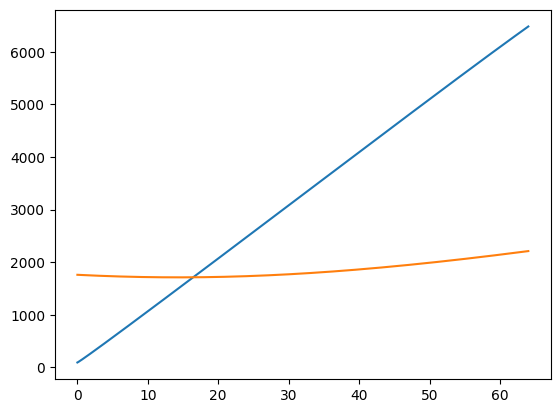

Model saved to trained_value_function.pt


In [6]:
if __name__ == "__main__":
    # Define parameters
    STATE_DIM = 1  # Just one, continuous state, the promised value. Next step will be adding (discrete) y
    ACTION_DIM = 1  # Adjust based on your problem
    HIDDEN_DIMS = [64,64]  # Decreasing width architecture
    pref = Preferences(input_param=p)
    
    LOWER_BOUNDS = [1/pref.utility_1d(p.u_bf_m)]
    UPPER_BOUNDS = [1/pref.utility_1d(10)] #Ideally this should come from fun_prod.max
    # Train value function
    print("Training value function...")
    trained_model = train_value_function(
        state_dim=STATE_DIM,
        lower_bounds=LOWER_BOUNDS,
        upper_bounds=UPPER_BOUNDS,
        action_dim=ACTION_DIM,
        hidden_dims=HIDDEN_DIMS,
        num_iterations=690,
        starting_points_per_iter=200,
        simulation_steps=5,
        learning_rate=0.003,
        parameters=p
    )
    
    # Evaluate trained model
    evaluate_value_function(trained_model, p, LOWER_BOUNDS, UPPER_BOUNDS)
    
    # Save the model
    torch.save(trained_model.state_dict(), "trained_value_function.pt")
    print("Model saved to trained_value_function.pt")

In [22]:
trained_model(torch.tensor([-40.0]))

tensor([3215.1104], grad_fn=<ViewBackward0>)